In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

### Explore the data

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# only had disaster tweets examples above
# example of what is not a disaster tweet
train_df[train_df["target"] == 0].head()

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0


In [5]:
# shape of dataset
train_df.shape

(7613, 5)

In [6]:
# count null values for keyword
train_df["keyword"].isna().sum()

61

In [7]:
# lets look at examples of keywords
train_df[train_df["keyword"].notna()].head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [8]:
# count null values for location
train_df["location"].isna().sum()

2533

In [9]:
# lets look at examples of location
train_df[train_df["location"].notna()].head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [10]:
# lets get an idea of vocab size
from collections import Counter
results = Counter()
train_df['text'].str.lower().str.split().apply(results.update)
print(len(results))

27983


In [11]:
# max length of tweet
train_df['text'].str.split().str.len().max()

31

In [12]:
# check for duplicate tweets
duplicates_df = train_df[train_df["text"].duplicated(keep=False)]
duplicates_df.shape

(179, 5)

In [13]:
# lets have a look
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       ):
    print(duplicates_df[['text','target']].sort_values('text'))

                                                   text  target
4290  #Allah describes piling up #wealth thinking it...       0
4299  #Allah describes piling up #wealth thinking it...       0
4312  #Allah describes piling up #wealth thinking it...       1
6363  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1
6373  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1
6377  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1
6378  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1
6392  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1
6366  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1
2828  #KCA #VoteJKT48ID 12News: UPDATE: A family of ...       1
2822  #KCA #VoteJKT48ID 12News: UPDATE: A family of ...       1
2816  #Myanmar  Displaced #Rohingya at #Sittwe point...       1
2841  #Myanmar  Displaced #Rohingya at #Sittwe point...       1
1704  #Newswatch: 2 vehicles collided at Lock and La...       1
1725  #Newswatch: 2 vehicles collided at

### Cleaning data

In [14]:
# search for contradictions
contradictory_tweets = set()
for tweet in duplicates_df['text']:
    if len(set(duplicates_df[duplicates_df['text']==tweet].target)) > 1:
        contradictory_tweets.add(tweet)

In [15]:
print(len(contradictory_tweets))

18


In [16]:
# not many will manually adjust the labels
contradictory_tweets = list(contradictory_tweets)
for i,v in enumerate(contradictory_tweets):
    print(f"{i}: {v}")

0: Caution: breathing may be hazardous to your health.
1: The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'
2: Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...
3: #Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect
4: I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????
5: Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her
 
#FARRAKHAN #QUOTE
6: Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife
7: that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time
8: He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam
9: wow

In [17]:
manual_labels = [0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0]
#check length is correct
len(manual_labels)

18

In [18]:
# make a copy
clean_train_df = train_df.copy()

In [19]:
# drop duplicates but keep first instance
clean_train_df = clean_train_df.drop_duplicates('text')

In [20]:
# adjust contradictory tweets following manual labelling
for i,v in enumerate(contradictory_tweets):
    clean_train_df.loc[clean_train_df['text'] == v,'target'] = manual_labels[i]

In [21]:
#check for right shape
clean_train_df.shape

(7503, 5)

### Text encoder


In [22]:
import tensorflow as tf

In [23]:
VOCAB_SIZE = 28000 # actual vocab size is ~28k in training set.
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(clean_train_df['text'])

In [24]:
# checking the encoding
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is', 'for',
       'on', 'you', 'my', 'that', 'it', 'with', 'at', 'by', 'this'],
      dtype='<U52')

### Create model
Will be using k-fold validation on data. Given size of data is roughly ~8k will set k = 4.

In [25]:
# model config
batch_size = 50
no_epochs = 10
verbosity = 2
num_folds = 4

In [26]:
# Define the model architecture
def create_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(1,), dtype=tf.string),
        encoder,
        tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1)
    ])
    return model

### Find optimal number of epochs to train for

In [27]:
# turn inputs + targets to numpy arrays
inputs = clean_train_df['text'].to_numpy()
targets = clean_train_df['target'].to_numpy()

In [28]:
# From previous experience, overfitting is a problem. Let's work out the optimal
# number of epochs to train for.

# Define the model architecture
model = create_model()

# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            optimizer=tf.keras.optimizers.Adam(1e-4),
            metrics=['accuracy'])

# Fit data to model
history = model.fit(inputs, targets,
          batch_size=batch_size,
          validation_split=0.25,
          epochs=10,
          verbose=verbosity)

Epoch 1/10
113/113 - 31s - loss: 0.6894 - accuracy: 0.5809 - val_loss: 0.6877 - val_accuracy: 0.5565 - 31s/epoch - 271ms/step
Epoch 2/10
113/113 - 8s - loss: 0.6635 - accuracy: 0.5809 - val_loss: 0.6373 - val_accuracy: 0.5565 - 8s/epoch - 68ms/step
Epoch 3/10
113/113 - 8s - loss: 0.5017 - accuracy: 0.7308 - val_loss: 0.5318 - val_accuracy: 0.7473 - 8s/epoch - 71ms/step
Epoch 4/10
113/113 - 8s - loss: 0.3183 - accuracy: 0.8832 - val_loss: 0.5824 - val_accuracy: 0.7537 - 8s/epoch - 72ms/step
Epoch 5/10
113/113 - 8s - loss: 0.2096 - accuracy: 0.9287 - val_loss: 0.6552 - val_accuracy: 0.7543 - 8s/epoch - 74ms/step
Epoch 6/10
113/113 - 8s - loss: 0.1379 - accuracy: 0.9570 - val_loss: 0.8155 - val_accuracy: 0.7468 - 8s/epoch - 72ms/step
Epoch 7/10
113/113 - 8s - loss: 0.0991 - accuracy: 0.9725 - val_loss: 0.9373 - val_accuracy: 0.7399 - 8s/epoch - 73ms/step
Epoch 8/10
113/113 - 9s - loss: 0.0650 - accuracy: 0.9822 - val_loss: 1.1136 - val_accuracy: 0.7175 - 9s/epoch - 77ms/step
Epoch 9/10
11

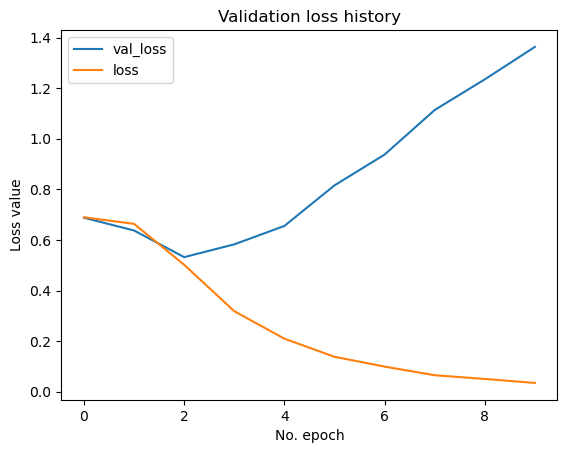

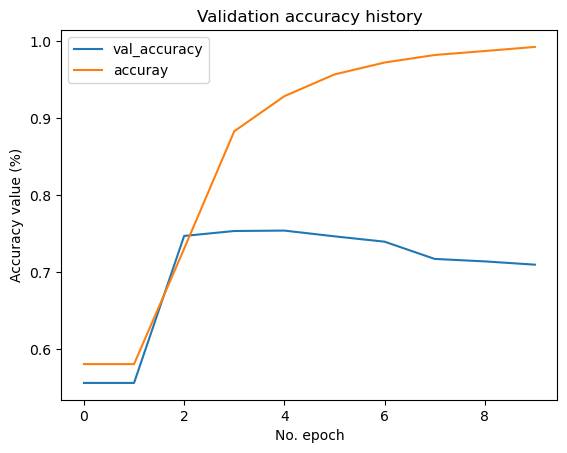

In [29]:
import matplotlib.pyplot as plt

# Visualize history
# Plot history: Loss
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss')
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

# Plot history: Accuracy
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['accuracy'], label='accuray')
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

From this it's clear we should only train the model for 3/4 epochs. Let's go for 3 since it's faster.

### K fold cross validation

In [30]:
from sklearn.model_selection import KFold

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

In [31]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

In [32]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  # Define the model architecture
  model = create_model()

  # Compile the model
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics=['accuracy'])


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(inputs[train], targets[train],
              batch_size=batch_size,
              epochs=3,
              verbose=verbosity)

  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
    
  model.save(f"/models/model_fold_{fold_no}")

  # Increase fold number
  fold_no = fold_no + 1


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/3
113/113 - 24s - loss: 0.6877 - accuracy: 0.5733 - 24s/epoch - 216ms/step
Epoch 2/3
113/113 - 8s - loss: 0.6344 - accuracy: 0.5776 - 8s/epoch - 69ms/step
Epoch 3/3
113/113 - 8s - loss: 0.4417 - accuracy: 0.8056 - 8s/epoch - 69ms/step
Score for fold 1: loss of 0.49011990427970886; accuracy of 78.67803573608398%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/3
113/113 - 26s - loss: 0.6886 - accuracy: 0.5756 - 26s/epoch - 230ms/step
Epoch 2/3
113/113 - 7s - loss: 0.6427 - accuracy: 0.5770 - 7s/epoch - 63ms/step
Epoch 3/3
113/113 - 7s - loss: 0.4640 - accuracy: 0.7935 - 7s/epoch - 64ms/step
Score for fold 2: loss of 0.4929364025592804; accuracy of 79.31769490242004%
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/3
113/113 - 24s - loss: 0.6896 - accuracy: 0.5790 - 24s/epoc

In [33]:
# Provide average scores
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.49011990427970886 - Accuracy: 78.67803573608398%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.4929364025592804 - Accuracy: 79.31769490242004%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.5332431197166443 - Accuracy: 77.02558636665344%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.47194644808769226 - Accuracy: 80.15999794006348%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 78.79532873630524 (+- 1.149014158967295)
> Loss: 0.49706146866083145
------------------------------------------------------------------------


Each fold is pretty similar apart. Lets train a model on the whole data but with only 3 epochs then.

In [34]:
# Define the model architecture
model = create_model()

# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            optimizer=tf.keras.optimizers.Adam(1e-4),
            metrics=['accuracy'])

# Fit data to model
history = model.fit(inputs, targets,
          batch_size=batch_size,
          epochs=3,
          verbose=verbosity)

Epoch 1/3
151/151 - 27s - loss: 0.6855 - accuracy: 0.5748 - 27s/epoch - 177ms/step
Epoch 2/3
151/151 - 10s - loss: 0.5904 - accuracy: 0.6104 - 10s/epoch - 64ms/step
Epoch 3/3
151/151 - 10s - loss: 0.3805 - accuracy: 0.8451 - 10s/epoch - 64ms/step


### Make predictions

In [35]:
non_binary_sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [36]:
# Given the small test sample, it will be faster to call the model directly rather than using the 
# predict method. 
non_binary_sample_submission["target"] = model(test_df['text'])

In [37]:
# turning this into binary output
sample_submission['target'] = non_binary_sample_submission['target'].apply(lambda x:0 if x < 0.5 else 1)

In [38]:
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1


In [39]:
sample_submission.to_csv("submission.csv", index=False)